In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import keras
from keras import layers
from loguru import logger
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
def _parse_audio(example_proto):
    return _parse_function(example_proto, 'audio')
def _parse_note_str(example_proto):
    return _parse_function(example_proto, 'note_str')
@tf.autograph.experimental.do_not_convert
def _parse_function(example_proto, col):
    # Schema
    features = {
        "audio": tf.io.FixedLenFeature([64000], dtype=tf.float32),
        "note_str": tf.io.FixedLenFeature([1], dtype=tf.string)
    }
    example = tf.io.parse_single_example(example_proto, features)
    data = example[col]
    return data, None
def get_id_prediction_df(model, data_path, batch_size=128):
    tf_records = tf.data \
        .TFRecordDataset(data_path)
    identifiers = [example[0].numpy()[0].decode() for example in tf_records.map(_parse_note_str)]
    audio_dataset = tf_records \
        .map(_parse_audio) \
        .batch(batch_size)
    predictions = model \
        .predict(audio_dataset) \
        .argmax(axis=1)
    return pd.DataFrame({'ids': identifiers, 'predictions': predictions})

model = tf.keras.models.load_model('../models/0505instrumentclassifier_5epoch')
df = get_id_prediction_df(model, data_path='../data/nsynth-test.tfrecord')








In [5]:
from pathlib import Path

def read_metadata(data_folder: Path, instrument_filter: str=None, filename: str="examples.json") -> pd.DataFrame:
    """
    Read an NSynth metadatafile from disk as pandas DataFrame.

    :param data_folder: root folder of dataset, for example `Path('./data/nsynth-test')`
    :param instrument_filter: exact name of instrument_str, Falsy reads all
    :param filename: default = "examples.json"
    :return: pandas DataFrame with sound-id as index
    """
    if type(data_folder) is str:
        data_folder = Path(data_folder)

    metadata_file = data_folder / filename
    metadata = pd \
        .read_json(metadata_file, orient='index')

    if instrument_filter:
        metadata = metadata.query('instrument_str == @INSTRUMENT')

    return metadata


In [6]:
#df = get_id_prediction_df(model, data_path='../data/nsynth-test.tfrecord')

jsondata = read_metadata("../data/nsynth-train")


In [8]:
jsondata

,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str
bass_synthetic_068-049-025,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",49,217499,synthetic,25,bass_synthetic_068,656,16000,[dark],2,bass_synthetic_068-049-025,0,bass
keyboard_electronic_001-021-127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,299359,electronic,127,keyboard_electronic_001,40,16000,[],1,keyboard_electronic_001-021-127,4,keyboard
guitar_acoustic_010-066-100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",66,72288,acoustic,100,guitar_acoustic_010,219,16000,[],0,guitar_acoustic_010-066-100,3,guitar
reed_acoustic_037-068-127,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",68,22259,acoustic,127,reed_acoustic_037,387,16000,[reverb],0,reed_acoustic_037-068-127,7,reed
flute_acoustic_002-077-100,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",77,72001,acoustic,100,flute_acoustic_002,86,16000,[reverb],0,flute_acoustic_002-077-100,2,flute
...,...,...,...,...,...,...,...,...,...,...,...,...,...
brass_acoustic_006-088-075,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",88,35344,acoustic,75,brass_acoustic_006,43,16000,[reverb],0,brass_acoustic_006-088-075,1,brass
organ_electronic_028-044-100,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",44,187148,electronic,100,organ_electronic_028,440,16000,[dark],1,organ_electronic_028-044-100,6,organ
string_acoustic_071-027-127,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",27,114253,acoustic,127,string_acoustic_071,609,16000,"[long_release, reverb]",0,string_acoustic_071-027-127,8,string
string_acoustic_057-063-127,"[1, 0, 0, 0, 0, 0, 1, 0, 1, 0]",63,58959,acoustic,127,string_acoustic_057,450,16000,"[bright, nonlinear_env, reverb]",0,string_acoustic_057-063-127,8,string


In [20]:
df = df.set_index('ids').join(jsondata)

In [24]:
df[['predictions', 'instrument_family']]
df['correct'] = df.predictions==df.instrument_family

<AxesSubplot:ylabel='Frequency'>

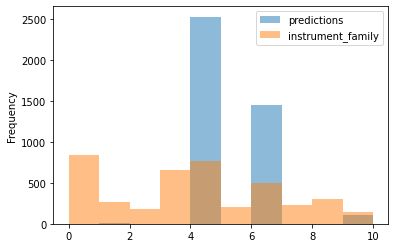

In [41]:
preds = df[['predictions', 'instrument_family', 'correct']]
preds.plot.hist(by='correct', alpha=0.5)